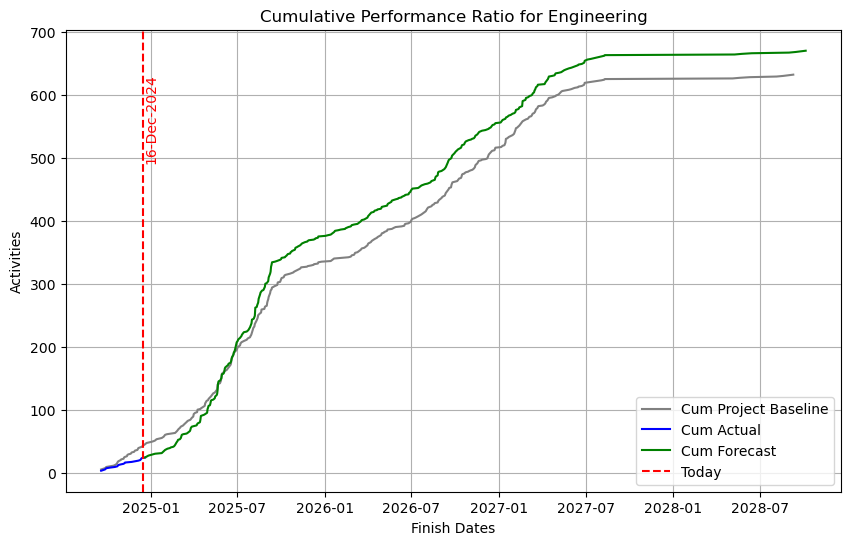

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo Excel
df = pd.read_excel('GPT - CPR (only Engineering).xlsx')

# Convertir las fechas a formato datetime
df['BL Project Finish'] = pd.to_datetime(df['BL Project Finish'], errors='coerce')
df['Actual Finish'] = pd.to_datetime(df['Actual Finish'], errors='coerce')
df['Early Finish'] = pd.to_datetime(df['Early Finish'], errors='coerce')

# Crear acumulados para baseline, actual y forecast
data_sorted_bl = df.sort_values(by='BL Project Finish').dropna(subset=['BL Project Finish'])
data_sorted_actual = df.sort_values(by='Actual Finish').dropna(subset=['Actual Finish'])
data_sorted_forecast = df.sort_values(by='Early Finish').dropna(subset=['Early Finish'])

cumulative_bl = data_sorted_bl.groupby('BL Project Finish').size().cumsum()
cumulative_actual = data_sorted_actual.groupby('Actual Finish').size().cumsum()
cumulative_forecast = data_sorted_forecast.groupby('Early Finish').size().cumsum()

# Ajustar el forecast para que comience donde termina el current month
if not cumulative_actual.empty:
    last_actual_date = cumulative_actual.index[-1]
    last_actual_value = cumulative_actual.iloc[-1]
    
    # Asegurar continuidad: el forecast comienza un día después del último punto de "Current Month"
    next_forecast_date = last_actual_date + pd.Timedelta(days=1)
    cumulative_forecast = cumulative_forecast[cumulative_forecast.index >= next_forecast_date]
    cumulative_forecast = pd.concat(
        [pd.Series({last_actual_date: last_actual_value}),
         cumulative_forecast + last_actual_value]
    )

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(cumulative_bl.index, cumulative_bl.values, label='Cum Project Baseline', color='gray')
plt.plot(cumulative_actual.index, cumulative_actual.values, label='Cum Actual', color='blue')
plt.plot(cumulative_forecast.index, cumulative_forecast.values, label='Cum Forecast', color='green')

# Agregar línea vertical para el día de hoy
today = pd.Timestamp.now()
plt.axvline(today, color='red', linestyle='--', label='Today')

# Etiquetar la fecha actual en el eje x con un pequeño desplazamiento
plt.text(today + pd.Timedelta(days=2), plt.ylim()[1] * 0.9, today.strftime('%d-%b-%Y'),
         color='red', rotation=90, va='top')

# Configurar título y etiquetas
plt.title('Cumulative Performance Ratio for Engineering')
plt.xlabel('Finish Dates')
plt.ylabel('Activities')
plt.legend()
plt.grid()

# Guardar el gráfico en formato PNG con fondo transparente
plt.savefig('CPR (only Engineering).png', format='png', transparent=True, dpi=300)

# Mostrar el gráfico
plt.show()


In [2]:
# Combinar datos de "Actual Finish" y "Early Finish" para crear "Actual/Forecast Completed"
data_sorted_actual_forecast = pd.concat(
    [
        data_sorted_actual[['Actual Finish']],  # Usar solo las fechas relevantes de Actual
        data_sorted_forecast[['Early Finish']].rename(columns={'Early Finish': 'Actual Finish'})  # Renombrar Early Finish a Actual Finish
    ]
).sort_values(by='Actual Finish').dropna(subset=['Actual Finish'])

# Agrupar los datos por mes y calcular los valores acumulativos correspondientes
cumulative_actual_forecast_by_month = data_sorted_actual_forecast.groupby(
    data_sorted_actual_forecast['Actual Finish'].dt.to_period('M')
).size().cumsum()

cumulative_bl_by_month = data_sorted_bl.groupby(
    data_sorted_bl['BL Project Finish'].dt.to_period('M')
).size().cumsum()

# Crear un DataFrame consolidado para los cálculos
cpr_table = pd.DataFrame({
    'Actual/Forecast Completed': cumulative_actual_forecast_by_month,
    'Planned Completed': cumulative_bl_by_month
}).fillna(0)  # Rellenar NaN con 0 para evitar problemas en cálculos

# Calcular el Cumulative Performance Ratio (CPR) con 2 decimales
cpr_table['CPR'] = (
    cpr_table['Actual/Forecast Completed'] / cpr_table['Planned Completed']
).replace([float('inf'), float('nan')], 0)
cpr_table['CPR'] = cpr_table['CPR'].round(2)  # Redondear el CPR a 2 decimales

# Resetear índice para mejorar la presentación
cpr_table = cpr_table.reset_index()
cpr_table.rename(columns={'index': 'Month'}, inplace=True)

# Mostrar la tabla
print(cpr_table)

# Opcional: guardar la tabla como archivo Excel
cpr_table.to_excel('CPR_(only_Engineering)_Table.xlsx', index=False)


      Month  Actual/Forecast Completed  Planned Completed   CPR
0   2024-09                          7                9.0  0.78
1   2024-10                         13               21.0  0.62
2   2024-11                         18               35.0  0.51
3   2024-12                         27               47.0  0.57
4   2025-01                         36               60.0  0.60
5   2025-02                         52               69.0  0.75
6   2025-03                         73               89.0  0.82
7   2025-04                        101              114.0  0.89
8   2025-05                        156              157.0  0.99
9   2025-06                        207              195.0  1.06
10  2025-07                        237              220.0  1.08
11  2025-08                        300              264.0  1.14
12  2025-09                        338              305.0  1.11
13  2025-10                        357              319.0  1.12
14  2025-11                        369  

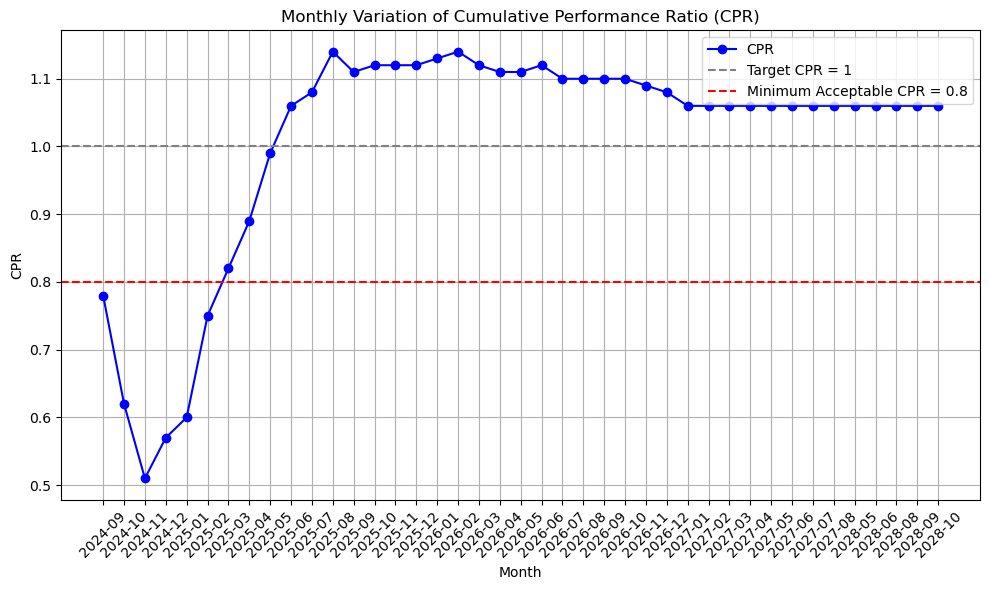

In [3]:
import numpy as np

# Antes de graficar, vamos a rellenar los valores 0 con interpolación
cpr_table['CPR'] = cpr_table['CPR'].replace(0, np.nan)  # Convertir 0s a NaN
cpr_table['CPR'] = cpr_table['CPR'].interpolate(method='linear')  # Interpolar valores faltantes

# Graficar la variación del CPR por mes
plt.figure(figsize=(10, 6))
plt.plot(cpr_table['Month'].astype(str), cpr_table['CPR'], 
         marker='o', linestyle='-', color='blue', label='CPR')

# Configurar título y etiquetas
plt.title('Monthly Variation of Cumulative Performance Ratio (CPR)')
plt.xlabel('Month')
plt.ylabel('CPR')

# Línea de referencia (CPR = 1, objetivo)
plt.axhline(y=1, color='gray', linestyle='--', label='Target CPR = 1')

# Línea del suelo (CPR = 0.8, mínimo aceptable)
plt.axhline(y=0.8, color='red', linestyle='--', label='Minimum Acceptable CPR = 0.8')

# Rotar las etiquetas del eje X para mayor claridad
plt.xticks(rotation=45)

# Añadir leyenda y cuadrícula
plt.legend()
plt.grid()

# Ajustar márgenes
plt.tight_layout()

# Guardar el gráfico en formato PNG con fondo transparente
plt.savefig('Monthly Variaton of CPR (only Engineering).png', 
            format='png', transparent=True, dpi=300)

# Mostrar el gráfico
plt.show()